## 3.2.1 CBOW 모델의 추론 처리
![그림 3-11](./fig_3-11.png)

In [1]:
# %load cbow_predict.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-0.78911375 -0.85169609  0.8080164  -0.80782814  0.02078487  0.28490181
  -1.41667635]]


## 3.4 CBOW 모델 구현
![그림 3-19](./fig_3-19.png)
![그림 3-20](./fig_3-20.png)

In [2]:
# %load simple_cbow.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

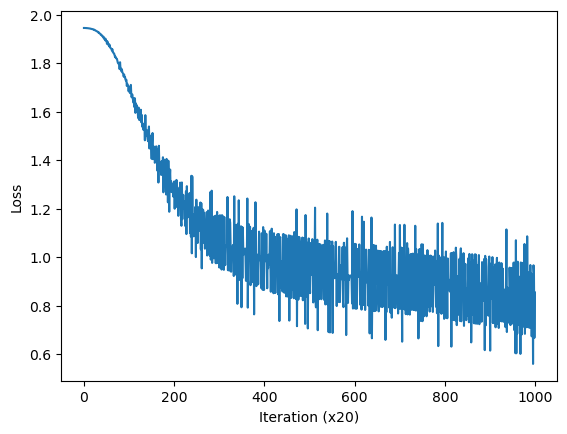

In [3]:
# %load train.py
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [4]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.2327125 -1.1990783 -1.1406192  1.1202226  1.1727974]
say [ 1.1883557  1.1441053  1.2112207 -1.0997984 -1.1743428]
goodbye [-0.75297576 -0.7240224  -0.80383116  0.78167456  0.77260035]
and [ 0.6374842   1.3820132   1.0180718  -1.5747082  -0.91124326]
i [-0.7507638  -0.7107261  -0.80654526  0.78140795  0.77341145]
hello [-1.215894  -1.2044047 -1.1796794  1.1272017  1.166288 ]
. [ 1.3903905   0.23880357  1.0384308   0.14069921 -1.1243062 ]


In [5]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [6]:
from common.util import cos_similarity

c0 = word_vecs[word_to_id['you']]  # "you"의 단어 벡터
c1 = word_vecs[word_to_id['i']]    # "i"의 단어 벡터
print(cos_similarity(c0, c1))

0.9975261


## 3.5.2 skip-gram 모델
![그림 3-24](fig_3-24.png)

In [7]:
# %load simple_skip_gram.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


## Train again with skip-gram

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 3.89
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 3.87
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 3.88
| 에폭 26 |

| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 2.73
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 2.62
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 2.52
| 에폭 257 |  반복 1 / 2 | 시간 0[s] | 손실 2.54
| 에폭 258 |  반복 1 / 2 | 시간 0[s] | 손실 2.71
| 에폭 259 |  반복 1 / 2 | 시간 0[s] | 손실 2.37
| 에폭 260 |  반복 1 / 2 | 시간 0[s] | 손실 2.60
| 에폭 261 |  반복 1 / 2 | 시간 0[s] | 손실 2.44
| 에폭 262 |  반복 1 / 2 | 시간 0[s] | 손실 2.77
| 에폭 263 |  반복 1 / 2 | 시간 0[s] | 손실 2.55
| 에폭 264 |  반복 1 / 2 | 시간 0[s] | 손실 2.48
| 에폭 265 |  반복 1 / 2 | 시간 0[s] | 손실 2.62
| 에폭 266 |  반복 1 / 2 | 시간 0[s] | 손실 2.54
| 에폭 267 |  반복 1 / 2 | 시간 0[s] | 손실 2.32
| 에폭 268 |  반복 1 / 2 | 시간 0[s] | 손실 2.61
| 에폭 269 |  반복 1 / 2 | 시간 0[s] | 손실 2.44
| 에폭 270 |  반복 1 / 2 | 시간 0[s] | 손실 2.71
| 에폭 271 |  반복 1 / 2 | 시간 0[s] | 손실 2.59
| 에폭 272 |  반복 1 / 2 | 시간 0[s] | 손실 2.40
| 에폭 273 |  반복 1 / 2 | 시간 0[s] | 손실 2.76
| 에폭 274 |  반복 1 / 2 | 시간 0[s] | 손실 2.28
| 에폭 275 |  반복 1 / 2 | 시간 0[s] | 손실 2.63
| 에폭 276 |  반복 1 / 2 | 시간 0[s] | 손실 2.45
| 에폭 277 |  반복 1 / 2 | 시간 0[s] | 손실 2.68
| 에폭 278 |  반복 1

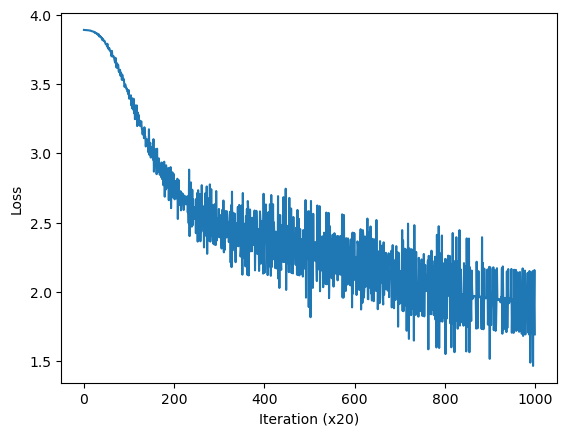

In [8]:
# %load train.py
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
#model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [9]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.01049776  0.00761873 -0.02253709 -0.00794773  0.00390067]
say [ 0.6834586  -0.76574594 -1.0571172   0.6059264  -0.40243548]
goodbye [-0.75008684  0.7523063   0.7945941  -0.73653215 -1.2379273 ]
and [ 1.0502466  -1.0189219  -0.85149103  1.0874898   1.4084836 ]
i [-0.74085224  0.7472789   0.7657719  -0.766458   -1.2312809 ]
hello [-0.90478337  0.9454686   0.8730815  -0.9285497   0.85381466]
. [0.0072136  0.01276082 0.00260139 0.00354608 0.01004237]


In [10]:
from common.util import cos_similarity

c0 = word_vecs[word_to_id['you']]  # "you"의 단어 벡터
c1 = word_vecs[word_to_id['i']]    # "i"의 단어 벡터
print(cos_similarity(c0, c1))

-0.04668404
